# Credit Card Fraud Detection System  
  
## Project Prototype
  
  
Author: Marco Fontana

## **Implementation** 

Before starting code development, I prepared an environment that would allow me to write and test the code and track all the changes I made.   
The project is written in a Jupyter Notebook, in Python, and uses several third-party libraries specific to Machine Learning and Deep Learning algorithms.  
Therefore, before I could write code, I had to install all the necessary components on my PC's operating system

In [7]:
# Install required libraries
!pip install numpy pandas tensorflow scikit-learn imbalanced-learn matplotlib

In [8]:
# Import required libraries
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, models, Model

### **Dataset analysis**

The first phase of the project is dedicated to the analysis of the dataset. Before proceeding to the implementation of the code, it is necessary to have a deep understanding of the available data in order to understand whether modifications are necessary to make the dataset suitable for ML and DL algorithms, thus increasing their performance.
Furthermore, since this dataset contains financial data, it is necessary to verify that there is no sensitive information of the user or payment institution, which could lead to confidentiality or ethical problems.

In the description of the dataset[] it is stated that for confidentiality reasons the content has been obscured via a PCA[] transformation; the feature name itself has been changed to a symbolic name (V1 to V28); the only features that have not been transformed or obfuscated are Time and Amount.  
The feature Time represents the number of seconds between each transaction and the first transaction, while Amount represents the amount of the transaction.  

Transforming and obfuscating the data and features of the dataset ensures that it does not contain sensitive information and guarantees that there are no confidentiality issues.

In [9]:
# Load the dataset
df = pd.read_csv('creditcard.csv')

# Show dataset info
df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'creditcard.csv'

The dataset consists of 284807 records and is described by 31 features.  
The data are all of type float64, except for the feature 'Class' which is of type int64.

#### **Checking for missing values**

The next step is to check for missing values in the dataset.

In [ ]:
print("\nNumber of missing values:", df.isnull().sum())

The dataset contains no missing values, so no manual editing operation is required.  
  
By visualizing an example of the records in the dataset, I can understand whether other operations are needed on the data that can improve performance with the ML and DL algorithms.

In [ ]:
# Display the first 5 records of the dataset
df.head(5)

From the analysis of some records, it can be seen that the Time and Amount features have not been transformed.
The Time feature is not useful in my research, since it does not provide a particular pattern related to the transaction; I could transform it into a date and time value, but since I have no information about the time of the first transaction I would have to create non-real data; that is why I decided to remove it from the dataset.

In [4]:
df = df.drop(columns=['Time'])

NameError: name 'df' is not defined

The 'Amount' feature is of type int64 and the values it contains can vary widely between transactons.  
Some ML algorithms (SVM, gradient boosting, etc.) perform better when features are on a similar scale, and since the feature ‘Amount’ can have a significant variance, scaling helps stabilise the performance of the model.

I did not delete the 'Amount' feature because the economic value of the transaction can be of great importance for identifying fraud patterns.  

In [5]:
#Apply scaling to the 'Amount' feature
df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

NameError: name 'df' is not defined

The StandardScaler is a data preprocessing technique commonly used in machine learning to scale or normalize features so that they have a mean of 0 and a standard deviation of 1. This is particularly important for many machine learning algorithms that are sensitive to the scale of input features, such as SVMs (Support Vector Machines), k-NN (k-Nearest Neighbors), and Logistic Regression. 
  
The state of the dataset after changes are made can be seen in the output below

In [6]:
df.head(5)

NameError: name 'df' is not defined

The dataset description page contains information on the distrubution of its two classes two classes 'non-fraud' (0) and 'fraud' (1).  
The amount of records of the two types is very different, as can be seen in the following output.

In [68]:
# Convert the Class column to a NumPy array
class_array = df['Class'].to_numpy()

# Calculate the percentage of Class 1 records (frauds)
percentage_class_1 = (np.sum(class_array == 1) / len(class_array)) * 100

print(f"Percentage of Class 1 records: {percentage_class_1:.3f}%")

Percentage of Class 1 records: 0.173%


The large imbalance in the distribution of classes in the dataset is a problem for some ML and DL algorithms, and so it is necessary to use techniques for its balancing.

#### Balancing the dataset

To obtain a dataset with an equivalent number of records for its classes, I will use several techniques and then compare the results with ML and DL algorithms. The goal is to test which method generates synthetic data that most closely resembles real data; artificially generated fraud records in fact could be classified as false negatives. By comparing the results I will be able to determine which of the balancing techniques is the most appropriate for generating this type of data.

It is important to note that the balancing of the dataset is done __after__ its division into training and test data, so that the latter contain no ‘synthetic’ data. 

I created a class which uses several oversampling methods: SMOTE, ADASYN, Borderline-SMOTE, SVMSMOTE and Random Oversampling. The selection of algorithms was evaluated after reading several researches that used them in their projects deemed them the best for oversampling the data.

In [69]:
class OversamplingTechniques:
    def __init__(self, X, y):
        """
        Initialize the class with the original dataset features (X) and target (y).
        """
        self.X = X
        self.y = y
        self.results = {}

    def apply_smote(self):
        """
        Apply SMOTE to the dataset and save the oversampled dataset.
        """
        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(self.X, self.y)
        self.results['SMOTE'] = (X_resampled, y_resampled)

    def apply_adasyn(self):
        """
        Apply ADASYN to the dataset and save the oversampled dataset.
        """
        adasyn = ADASYN(random_state=42)
        X_resampled, y_resampled = adasyn.fit_resample(self.X, self.y)
        self.results['ADASYN'] = (X_resampled, y_resampled)

    def apply_borderline_smote(self):
        """
        Apply Borderline-SMOTE to the dataset and save the oversampled dataset.
        """
        borderline_smote = BorderlineSMOTE(random_state=42)
        
        X_resampled, y_resampled = borderline_smote.fit_resample(self.X, self.y)
        self.results['Borderline-SMOTE'] = (X_resampled, y_resampled)

    def apply_random_oversampling(self):
        """
        Apply Random Oversampling to the dataset and save the oversampled dataset.
        """
        random_oversampler = RandomOverSampler(random_state=42)
        X_resampled, y_resampled = random_oversampler.fit_resample(self.X, self.y)
        self.results['Random Oversampling'] = (X_resampled, y_resampled)
    
    def get_resampled_data(self, method):
        """
        Retrieve the resampled dataset for a given oversampling method.
        :param method: String indicating the oversampling method (e.g., 'SMOTE').
        :return: Tuple of resampled features (X) and target (y).
        """
        return self.results.get(method, None)


Oversampling of the dataset is done on the training data only, so that the test data does not contain synthetic data.
I decided to reserve 70% of the dataset for training and the remaining 30% for testing. Before applying oversampling, I separated the labels from the data.

In [70]:
# Separate features and labels
X = df.drop(columns=['Class'])  # Features
y = df['Class']                 # Labels

# Split the data into train and test sets (to avoid data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

Visualizing the class distribution makes the imbalance of the dataset more evident. 
There are  284315 class 0 (non-fraud) records and 492 class 1 (fraud) records.

In [78]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import layers, Model

# Step 1: Read the dataset
# Replace 'creditcard.csv' with the correct path to the dataset
df = pd.read_csv('creditcard.csv')

# Step 2: Preprocess the data
# Separate features (X) and target (y)
X = df.drop(columns=['Class'])
y = df['Class']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

# Separate majority and minority classes in training data
X_train_majority = X_train[y_train == 0]
X_train_minority = X_train[y_train == 1]

# Step 3: Define GAN architecture
def build_gan(latent_dim, n_features):
    """
    Build Generator, Discriminator, and GAN for GAN-based oversampling.
    """
    # Generator
    generator = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=latent_dim),
        layers.Dense(128, activation='relu'),
        layers.Dense(n_features, activation='tanh')
    ])

    # Discriminator
    discriminator = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=n_features),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

    # GAN
    discriminator.trainable = False
    gan_input = layers.Input(shape=(latent_dim,))
    gan_output = discriminator(generator(gan_input))
    gan_model = Model(gan_input, gan_output)
    gan_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='binary_crossentropy')

    return generator, discriminator, gan_model

# Step 4: Train GAN
def train_gan(generator, discriminator, gan_model, X_minority, latent_dim, epochs, batch_size):
    """
    Train GAN to generate synthetic samples for the minority class.
    """
    for epoch in range(epochs):
        # Generate fake samples
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        fake_samples = generator.predict(noise)

        # Select real samples
        idx = np.random.randint(0, X_minority.shape[0], batch_size)
        real_samples = X_minority[idx]

        # Labels for real and fake samples
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train discriminator
        d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)

        # Train generator
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        g_loss = gan_model.train_on_batch(noise, real_labels)

        # Log progress
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: D Loss Real = {d_loss_real}, D Loss Fake = {d_loss_fake}, G Loss = {g_loss}")

# Step 5: Define WGAN architecture
def build_wgan(latent_dim, n_features):
    """
    Build Generator and Critic for WGAN-based oversampling.
    """
    # Generator
    generator = tf.keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=latent_dim),
        layers.Dense(128, activation='relu'),
        layers.Dense(n_features, activation='tanh')
    ])

    # Critic
    critic = tf.keras.Sequential([
        layers.Dense(128, activation='relu', input_dim=n_features),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Outputs a score, not a probability
    ])
    critic.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002), loss='mse')  # Critic loss

    return generator, critic

# Step 6: Train WGAN
def train_wgan(generator, critic, X_minority, latent_dim, epochs, batch_size, critic_steps=5):
    """
    Train WGAN to generate synthetic samples for the minority class.
    """
    for epoch in range(epochs):
        for _ in range(critic_steps):
            # Generate fake samples
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            fake_samples = generator.predict(noise)

            # Select real samples
            idx = np.random.randint(0, X_minority.shape[0], batch_size)
            real_samples = X_minority[idx]

            # Train critic
            real_labels = np.ones((batch_size, 1))
            fake_labels = -np.ones((batch_size, 1))
            real_loss = critic.train_on_batch(real_samples, real_labels)
            fake_loss = critic.train_on_batch(fake_samples, fake_labels)

        # Train generator
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
        g_loss = critic.train_on_batch(generator.predict(noise), real_labels)

        # Log progress
        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Critic Loss = {real_loss + fake_loss}, G Loss = {g_loss}")

# Step 7: Apply GAN for oversampling
latent_dim = 32
n_features = X_train.shape[1]
batch_size = 64
epochs = 5000

# Train GAN
generator_gan, discriminator_gan, gan_model = build_gan(latent_dim, n_features)
train_gan(generator_gan, discriminator_gan, gan_model, X_train_minority, latent_dim, epochs, batch_size)

# Generate synthetic samples
noise = np.random.normal(0, 1, size=(len(X_train_minority), latent_dim))
synthetic_samples_gan = generator_gan.predict(noise)

# Combine synthetic samples with original dataset
X_train_gan = np.vstack((X_train, synthetic_samples_gan))
y_train_gan = np.hstack((y_train, np.ones(len(synthetic_samples_gan))))

# Shuffle the dataset
X_train_gan, y_train_gan = shuffle(X_train_gan, y_train_gan, random_state=42)

# Step 8: Apply WGAN for oversampling
generator_wgan, critic_wgan = build_wgan(latent_dim, n_features)
train_wgan(generator_wgan, critic_wgan, X_train_minority, latent_dim, epochs, batch_size)

# Generate synthetic samples
noise = np.random.normal(0, 1, size=(len(X_train_minority), latent_dim))
synthetic_samples_wgan = generator_wgan.predict(noise)

# Combine synthetic samples with original dataset
X_train_wgan = np.vstack((X_train, synthetic_samples_wgan))
y_train_wgan = np.hstack((y_train, np.ones(len(synthetic_samples_wgan))))

# Shuffle the dataset
X_train_wgan, y_train_wgan = shuffle(X_train_wgan, y_train_wgan, random_state=42)

# Step 9: Results
print("GAN-oversampled dataset shape:", X_train_gan.shape, y_train_gan.shape)
print("WGAN-oversampled dataset shape:", X_train_wgan.shape, y_train_wgan.shape)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/home/kino/dev/CM3070/code/.final/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'NoneType' object has no attribute 'update_state'

Class Distribution Before oversampling:
Class
0    284315
1       492
Name: count, dtype: int64


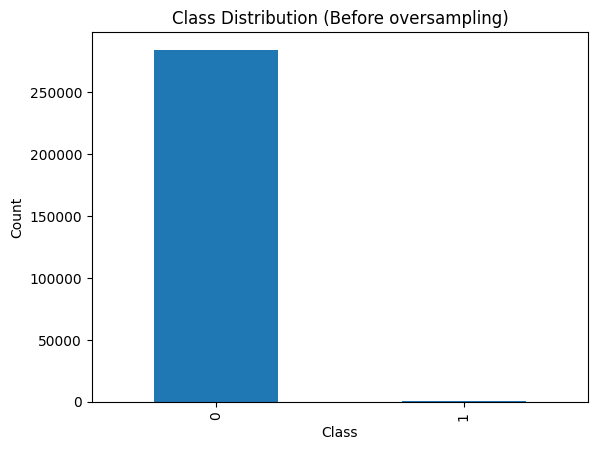

In [71]:
# Display class distribution before any oversampling technique is applied
print("Class Distribution Before oversampling:")
print(df['Class'].value_counts())
df['Class'].value_counts().plot(kind='bar', title='Class Distribution (Before oversampling)', xlabel='Class', ylabel='Count')
plt.show()

In [75]:
class GANOversampling:
    def __init__(self, X, y):
        """
        Initialize the class with the original dataset features (X) and target (y).
        """
        self.X = X
        self.y = y
        self.results = {}

    def apply_gan(self, latent_dim=100, epochs=5000, batch_size=64):
        """
        Apply GAN to generate synthetic data for the minority class.
        """
        X_minority = self.X[self.y == 1]  # Filter minority class
        n_minority_samples = X_minority.shape[0]
        generator, discriminator, gan_model = self._build_gan(latent_dim, X_minority.shape[1])

        # Train GAN
        self._train_gan(generator, discriminator, gan_model, X_minority, latent_dim, epochs, batch_size)

        # Generate synthetic samples
        noise = np.random.normal(0, 1, size=(n_minority_samples, latent_dim))
        synthetic_data = generator.predict(noise)

        # Combine synthetic and original data
        X_resampled = np.vstack((self.X, synthetic_data))
        y_resampled = np.hstack((self.y, np.ones(len(synthetic_data))))

        # Shuffle the dataset
        X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)

        self.results['GAN'] = (X_resampled, y_resampled)

    def apply_wgan(self, latent_dim=100, epochs=5000, batch_size=64):
        """
        Apply WGAN to generate synthetic data for the minority class.
        """
        X_minority = self.X[self.y == 1]  # Filter minority class
        n_minority_samples = X_minority.shape[0]
        generator, critic = self._build_wgan(latent_dim, X_minority.shape[1])

        # Train WGAN
        self._train_wgan(generator, critic, X_minority, latent_dim, epochs, batch_size)

        # Generate synthetic samples
        noise = np.random.normal(0, 1, size=(n_minority_samples, latent_dim))
        synthetic_data = generator.predict(noise)

        # Combine synthetic and original data
        X_resampled = np.vstack((self.X, synthetic_data))
        y_resampled = np.hstack((self.y, np.ones(len(synthetic_data))))

        # Shuffle the dataset
        X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=42)

        self.results['WGAN'] = (X_resampled, y_resampled)

    # --- Helper functions for GAN ---
    def _build_gan(self, latent_dim, n_features):
        """
        Build the generator, discriminator, and GAN model.
        """
        # Generator
        generator = tf.keras.Sequential([
            layers.Dense(128, activation='relu', input_dim=latent_dim),
            layers.Dense(64, activation='relu'),
            layers.Dense(n_features, activation='tanh')
        ])

        # Discriminator
        discriminator = tf.keras.Sequential([
            layers.Dense(128, activation='relu', input_dim=n_features),
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ])
        discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # GAN (Generator + Discriminator)
        discriminator.trainable = False
        gan_input = layers.Input(shape=(latent_dim,))
        gan_output = discriminator(generator(gan_input))
        gan_model = Model(gan_input, gan_output)
        gan_model.compile(optimizer='adam', loss='binary_crossentropy')

        return generator, discriminator, gan_model

    def _train_gan(self, generator, discriminator, gan_model, X_minority, latent_dim, epochs, batch_size):
        """
        Train the GAN model.
        """
        for epoch in range(epochs):
            # Generate fake data
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            fake_data = generator.predict(noise)

            # Select real data
            idx = np.random.randint(0, X_minority.shape[0], batch_size)
            real_data = X_minority.iloc[idx]

            # Train discriminator
            d_loss_real = discriminator.train_on_batch(real_data, np.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch(fake_data, np.zeros((batch_size, 1)))

            # Train generator
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            g_loss = gan_model.train_on_batch(noise, np.ones((batch_size, 1)))

            # Optionally log progress
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, D Loss: {d_loss_real + d_loss_fake}, G Loss: {g_loss}")

    # --- Helper functions for WGAN ---
    def _build_wgan(self, latent_dim, n_features):
        """
        Build the generator and critic for WGAN.
        """
        # Generator
        generator = tf.keras.Sequential([
            layers.Dense(128, activation='relu', input_dim=latent_dim),
            layers.Dense(64, activation='relu'),
            layers.Dense(n_features, activation='tanh')
        ])

        # Critic (similar to a discriminator, but outputs real-valued scores instead of probabilities)
        critic = tf.keras.Sequential([
            layers.Dense(128, activation='relu', input_dim=n_features),
            layers.Dense(64, activation='relu'),
            layers.Dense(1)
        ])
        critic.compile(optimizer='adam', loss='mse')  # Loss function for WGAN critic

        return generator, critic

    def _train_wgan(self, generator, critic, X_minority, latent_dim, epochs, batch_size):
        """
        Train the WGAN model.
        """
        for epoch in range(epochs):
            # Generate fake data
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            fake_data = generator.predict(noise)

            # Select real data
            idx = np.random.randint(0, X_minority.shape[0], batch_size)
            real_data = X_minority[idx]

            # Train critic
            real_loss = critic.train_on_batch(real_data, np.ones((batch_size, 1)))
            fake_loss = critic.train_on_batch(fake_data, -np.ones((batch_size, 1)))

            # Train generator
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            g_loss = critic.train_on_batch(generator.predict(noise), np.ones((batch_size, 1)))

            # Optionally log progress
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, Critic Loss: {real_loss + fake_loss}, G Loss: {g_loss}")

    def get_resampled_data(self, method):
        """
        Retrieve the resampled dataset for a given oversampling method.
        :param method: String indicating the oversampling method (e.g., 'SMOTE', 'GAN', or 'WGAN').
        :return: Tuple of resampled features (X) and target (y).
        """
        return self.results.get(method, None)


In [76]:
print(X.columns)  # Check column names
print(X.index)    # Check row indices
print(X.shape)    # Check shape of the DataFrame

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')
RangeIndex(start=0, stop=284807, step=1)
(284807, 29)


In [77]:
ganOversampling = GANOversampling(X_train, y_train)
ganOversampling.apply_gan()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


/home/kino/dev/CM3070/code/.final/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


AttributeError: 'NoneType' object has no attribute 'update_state'

In [44]:
# Initialize the OversamplingTechniques class with training data
oversampling = OversamplingTechniques(X_train, y_train)

# Apply different oversampling techniques
oversampling.apply_smote()
oversampling.apply_adasyn()
oversampling.apply_borderline_smote()
oversampling.apply_random_oversampling()
oversampling.apply_gan()
oversampling.apply_wgan()

AttributeError: 'OversamplingTechniques' object has no attribute '_build_gan'

Training Class Distribution After SMOTE:
Class
0    199020
1    199020
Name: count, dtype: int64


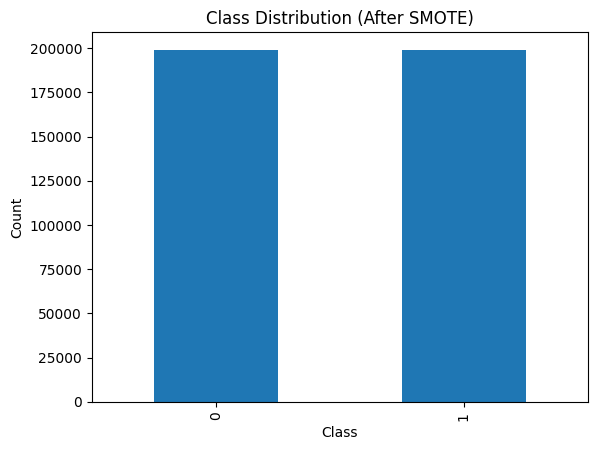

In [35]:
# Apply SMOTE to balance the training data
smote_X, smote_y = oversampling.get_resampled_data('SMOTE')

# Check class distribution after SMOTE
print("Training Class Distribution After SMOTE:")
print(pd.Series(smote_y).value_counts())

# Visualize the balanced class distribution
pd.Series(smote_y).value_counts().plot(kind='bar', title='Class Distribution (After SMOTE)', xlabel='Class', ylabel='Count')
plt.show()

#### Class for calculating the time taken to execute the code

In [36]:
import time

class Timer:
    def __init__(self):
        """Initialize the timer with no start time"""
        self.start_time = None

    def start(self):
        """Start the timer"""
        self.start_time = time.time()        

    def elapsed(self):
        """Calculate the time elapsed since the timer was started"""
        if self.start_time is None:
            raise ValueError("Timer has not been started. Call `start()` before `elapsed()`")
        elapsed_time = time.time() - self.start_time
        return elapsed_time

    def stop(self):
        """Stop the timer and reset the start_time"""
        self.start_time = None

# Create the Timer object
timer = Timer()

#### Machine Learning models

In [ ]:
# Start the timer
timer.start()

# Train a Random Forest Classifier on the balanced dataset
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

In [ ]:
# Start the timer
timer.start()

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

# Evaluate the model
print("Classification Report:\n", classification_report(y_pred, y_test))
print("Accuracy:", accuracy_score(y_pred, y_test))

# Visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.matshow(conf_matrix, cmap='Blues', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()


In [ ]:
# Build the Autoencoder model
def build_autoencoder(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        # Encoder
        layers.Dense(32, activation='relu'),
        layers.Dense(16, activation='relu'),
        layers.Dense(8, activation='relu'),  # Bottleneck (compressed representation)
        # Decoder
        layers.Dense(16, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(input_dim, activation='sigmoid')  # Output layer matches input
    ])
    return model

In [ ]:
# Separate features and labels
# The Class feature is not required in an unsupervised learning model
X = df.drop(columns=['Class'], axis=1)  # Features
y = df['Class']  # Labels

# Normalize the features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Separate normal (non-fraudulent) transactions for training the Autoencoder
X_normal = X_normalized[y == 0]

# Split the normal transactions into training and validation sets
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# Initialize the Autoencoder
input_dim = X_train.shape[1]
autoencoder = build_autoencoder(input_dim)

# Compile the Autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Start the timer
timer.start()

# Train the Autoencoder
history = autoencoder.fit(
    X_train, X_train,  # Input is the same as the target
    validation_data=(X_val, X_val),
    epochs=50,
    batch_size=64,
    verbose=1
)   

# Calculate the elapsed time for the training
elapsed_time = timer.elapsed()
print(f"Elapsed time: {elapsed_time:.2f} seconds")
timer.stop()

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Use the Autoencoder to calculate reconstruction errors
X_reconstructed = autoencoder.predict(X_normalized)
reconstruction_errors = np.mean(np.square(X_normalized - X_reconstructed), axis=1)

# Set a threshold for anomalies based on normal transactions' errors
threshold = np.percentile(reconstruction_errors[y == 0], 99)  # 98th percentile

# Classify anomalies (fraud) based on reconstruction error
y_pred = (reconstruction_errors > threshold).astype(int)

# Evaluate the results
print("Classification Report:\n", classification_report(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print("Accuracy:", accuracy_score(y, y_pred))

# Visualize reconstruction error distributions
plt.figure(figsize=(8, 5))
plt.hist(reconstruction_errors[y == 0], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_errors[y == 1], bins=50, alpha=0.6, label='Fraud')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.title('Reconstruction Error Distribution')
plt.show()

In [ ]:
# Visualize confusion matrix
conf_matrix = confusion_matrix(y, y_pred)
plt.matshow(conf_matrix, cmap='Blues', alpha=0.7)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

plt.title('Confusion Matrix')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.show()

In [ ]:
# Install necessary libraries (uncomment if needed)
# !pip install cudf-cu11 cuml-cu11 --extra-index-url=https://pypi.nvidia.com
# !pip install tensorflow keras

import cudf
import cuml
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop
from cuml.preprocessing import MinMaxScaler

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# ============================================
# Step 1: Load and preprocess the dataset
# ============================================
# Load the dataset using RAPIDS (GPU-accelerated Pandas alternative)
data_path = "creditcard.csv"  # Replace with the path to the Kaggle dataset
df = cudf.read_csv(data_path)

# Filter only fraud transactions (Class == 1)
fraud_data = df[df["Class"] == 1].reset_index(drop=True)
fraud_data = fraud_data.drop(["Class"], axis=1)  # Drop the class label as we focus on features

# Scale features using RAPIDS MinMaxScaler
scaler = MinMaxScaler()
fraud_data_scaled = scaler.fit_transform(fraud_data)

# Convert scaled fraud data back to NumPy for TensorFlow compatibility
fraud_data_np = fraud_data_scaled.astype(np.float32)

# ============================================
# Step 2: Define the WGAN architecture
# ============================================

# Define constants
LATENT_DIM = 100  # Size of the noise vector (input to the generator)
FEATURE_DIM = fraud_data_np.shape[1]  # Number of features in the fraud data
N_CRITIC = 5  # Number of discriminator updates per generator update
CLIP_VALUE = 0.01  # Weight clipping value

# Define the generator
def build_generator():
    input_noise = Input(shape=(LATENT_DIM,))
    x = Dense(128)(input_noise)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Dense(FEATURE_DIM, activation="tanh")(x)
    return Model(input_noise, x, name="Generator")

# Define the discriminator (critic in WGAN terms)
def build_critic():
    input_data = Input(shape=(FEATURE_DIM,))
    x = Dense(256)(input_data)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(128)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1)(x)  # Output is unbounded for Wasserstein loss
    return Model(input_data, x, name="Critic")

# Initialize generator and critic
generator = build_generator()
critic = build_critic()

# Define optimizers
optimizer = RMSprop(learning_rate=0.00005)

# Compile critic
critic.compile(loss="mse", optimizer=optimizer)

# ============================================
# Step 3: WGAN Training Loop
# ============================================

# Function to generate random noise
def generate_noise(batch_size):
    return np.random.normal(0, 1, (batch_size, LATENT_DIM))

# Function to train WGAN
def train_wgan(data, epochs=10000, batch_size=64):
    half_batch = batch_size // 2
    
    # Training loop
    for epoch in range(epochs):
        for _ in range(N_CRITIC):
            # Sample real data and generate fake data
            idx = np.random.randint(0, data.shape[0], half_batch)
            real_samples = data[idx]
            noise = generate_noise(half_batch)
            fake_samples = generator.predict(noise)
            
            # Train critic
            real_loss = critic.train_on_batch(real_samples, -np.ones((half_batch, 1)))
            fake_loss = critic.train_on_batch(fake_samples, np.ones((half_batch, 1)))
            critic_loss = 0.5 * np.add(real_loss, fake_loss)
            
            # Clip critic weights
            for layer in critic.layers:
                weights = layer.get_weights()
                weights = [np.clip(w, -CLIP_VALUE, CLIP_VALUE) for w in weights]
                layer.set_weights(weights)
        
        # Train generator
        noise = generate_noise(batch_size)
        generator_loss = critic.train_on_batch(generator.predict(noise), -np.ones((batch_size, 1)))
        
        # Print progress
        if epoch % 100 == 0:
            print(f"Epoch {epoch} | Critic Loss: {critic_loss:.4f} | Generator Loss: {generator_loss:.4f}")
    
    return generator

# Train the WGAN
generator_trained = train_wgan(fraud_data_np, epochs=5000, batch_size=128)

# ============================================
# Step 4: Generate synthetic fraud transactions
# ============================================
def generate_synthetic_data(generator, num_samples):
    noise = generate_noise(num_samples)
    synthetic_data = generator.predict(noise)
    synthetic_data_rescaled = scaler.inverse_transform(synthetic_data)
    return synthetic_data_rescaled

# Generate 1000 synthetic fraud samples
synthetic_fraud_data = generate_synthetic_data(generator_trained, num_samples=1000)

# Convert synthetic data to Pandas DataFrame for further use
synthetic_fraud_df = pd.DataFrame(synthetic_fraud_data, columns=fraud_data.columns)

# Save to CSV
synthetic_fraud_df.to_csv("synthetic_fraud_data.csv", index=False)
print("Synthetic fraud data saved as synthetic_fraud_data.csv")
